In [1]:
# This notebook accompanies the blog post found here https://ivanritter.github.io/blog/sentiment_analysis_using_lstm/
# We build a model to perform sentiment analysis using amazon customer reviews with PyTorch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch,torchtext

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from collections import Counter 
from torchtext.vocab import Vocab
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence
plt.rcParams['figure.figsize'] = 10,6 

In [3]:
# Check if GPU is available. If not training is performed on CPU.
# I do not recommend training on CPU. If you have no GPU try Google Colab 
if torch.cuda.is_available():
    dev = 'cuda:0'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print('executed on : GPU')
else:
    dev = 'cpu'
    print('executed on : CPU')

device = torch.device(dev)

executed on : GPU


In [4]:
# Path to the location of the data like .../..../amazon_reviews_us_Electronics_v1_00.tsv
path = '/content/drive/MyDrive/amazon_reviews_us_Electronics_v1_00.tsv'

# Load data into pandas data frame. Do not worry if some reviews are skipped 
df  = pd.read_csv(path,delimiter='\t',encoding='utf-8',error_bad_lines=False)

b'Skipping line 9076: expected 15 fields, saw 22\nSkipping line 19256: expected 15 fields, saw 22\nSkipping line 24313: expected 15 fields, saw 22\nSkipping line 47211: expected 15 fields, saw 22\nSkipping line 54295: expected 15 fields, saw 22\nSkipping line 56641: expected 15 fields, saw 22\nSkipping line 63067: expected 15 fields, saw 22\n'
b'Skipping line 93796: expected 15 fields, saw 22\n'
b'Skipping line 132806: expected 15 fields, saw 22\nSkipping line 164631: expected 15 fields, saw 22\nSkipping line 167019: expected 15 fields, saw 22\nSkipping line 167212: expected 15 fields, saw 22\n'
b'Skipping line 198103: expected 15 fields, saw 22\nSkipping line 199191: expected 15 fields, saw 22\nSkipping line 202841: expected 15 fields, saw 22\nSkipping line 218228: expected 15 fields, saw 22\nSkipping line 235900: expected 15 fields, saw 22\n'
b'Skipping line 277761: expected 15 fields, saw 22\nSkipping line 304582: expected 15 fields, saw 22\nSkipping line 312029: expected 15 fields,

In [5]:
# Information included in the data set. Each corresponding to a column of the frame 
list(df.columns)

['marketplace',
 'customer_id',
 'review_id',
 'product_id',
 'product_parent',
 'product_title',
 'product_category',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date']

In [6]:
# We are only interested in the star rating and the review text. So, we neglect all other information
df = df.loc[:,['star_rating','review_body']]

# Rename columns
df.columns = ['rating','review']

In [7]:
# Print the first 5 reviews
df.head()

,rating,review
0,5,As described.
1,5,It works as advertising.
2,5,Works pissa
3,1,Did not work at all.
4,5,Works well. Bass is somewhat lacking but is pr...


In [8]:
# Drop reviews whose text consists only of a number or comes without any text
mask = np.invert(df.review.apply(lambda x : isinstance(x,int) or isinstance(x,float)))
df   = df[mask]
df.review = df.review.apply(lambda x : x if len(x) > 0 else np.nan)
df.dropna(inplace=True)

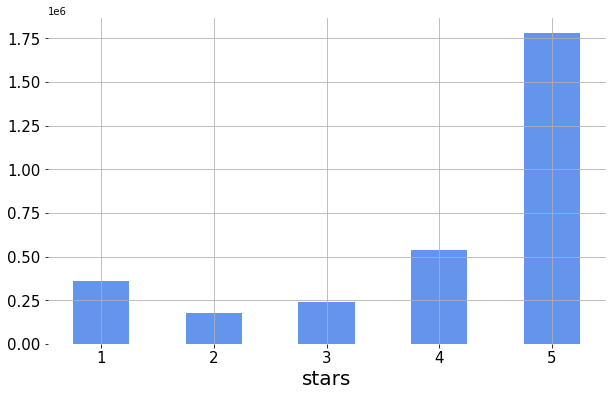

In [9]:
# Plot histogram of reviews with a certain star rating
labels, counts = np.unique(df.rating.to_numpy(), return_counts=True)
plt.bar(labels, counts, align='center',color='cornflowerblue',width=0.5)
plt.gca().set_xticks(labels)
plt.xticks(size=15)
plt.yticks(size=15)
plt.box(False)
plt.grid(True)
plt.xlabel('stars',size=20)
plt.show()

In [10]:
# We assume the reviews with stars < 4 belongs to class 0 "negative" and
# reviews with stars >= 4 belong to class 1 "positive"
# To make the two classes balanced we sample the same amount of reviews from each class

n_reviews = [25000,25000,25000,37500,37500]
rating_counts = list(df.rating.value_counts().sort_index())
for i in range(5):
    n_redundant_reviews = rating_counts[i] - n_reviews[i]
    mask = np.random.choice(np.arange(len(df.rating))[df.rating == i+1], n_redundant_reviews,replace=False)
    df = df.drop(df.index[mask])

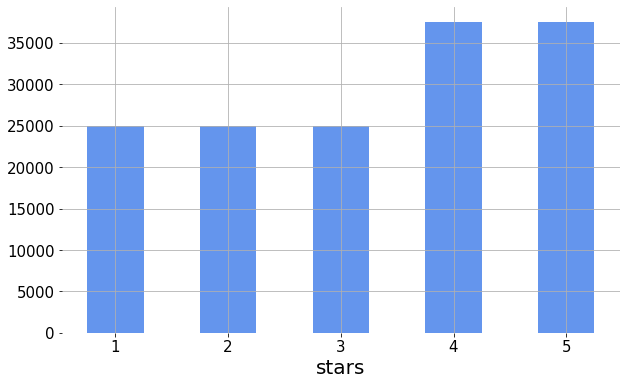

In [11]:
# Plot histogram for the new sampled data
labels, counts = np.unique(df.rating.to_numpy(), return_counts=True)
plt.bar(labels, counts, align='center',color='cornflowerblue',width=0.5)
plt.gca().set_xticks(labels)
plt.xticks(size=15)
plt.yticks(size=15)
plt.box(False)
plt.grid(True)
plt.xlabel('stars',size=20)
plt.show()

In [12]:
# Remove punctuation
import string
def remove_punctuation(text):
    return ''.join([w for w in text if w not in string.punctuation])
df.review = df.review.apply(lambda x: remove_punctuation(x))

In [13]:
# List of stopwords we remove.
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [14]:
# Tokenize words
tokenizer = get_tokenizer('basic_english')
def remove_stopwords(text):
    tokenized_text = tokenizer(text.lower())
    return ' '.join([w for w in tokenized_text if not w in stopwords])
df.review = df.review.apply(lambda x : remove_stopwords(x))

In [15]:
# Create vocabulary to encode words to integers
# We consider only unique words which have a minimum frequency of 5 in the data.
# It allows to remove uncommon typos and non-words like "gfhsdfju"
min_freq = 5
counter = Counter()
for line in df.review:
    counter.update(tokenizer(line.lower()))
vocab = Vocab(counter,min_freq=min_freq)

In [16]:
# Split data into data for training, testing and validation
df.review = df.review.apply(lambda x : x if len(x) > 0 else np.nan)
df.dropna(inplace=True)
df_train,df_test = train_test_split(df,test_size=0.2,shuffle=True)
df_test,df_val   = train_test_split(df_test,test_size=0.5,shuffle=True)

In [17]:
# Generator function providing mini batches with text data and corresponding class label
# The data in the batches is padded and packed to allow for efficient calculations
def get_batch(data_series,target_series,batch_size):
    series_len = len(data_series)
    n_batches = series_len // batch_size
    for i in range(0,n_batches):
        tmp_data = data_series.iloc[i*batch_size:(i+1)*batch_size]
        tmp_targets = target_series.iloc[i*batch_size:(i+1)*batch_size]

        data = []
        targets = torch.zeros(batch_size,dtype=torch.long)

        for j in range(batch_size):
            data.append(model.embedding(
                torch.tensor([vocab[w] for w in tokenizer(tmp_data.iloc[j].lower())],dtype=torch.long)
            ))
            # Setting the decision boarder for the classes
            targets[j] = 1 if tmp_targets.iloc[j] >= 4 else 0

        # pad and pack the data for efficient computation
        pad_data = pad_sequence(data)
        lengths = torch.tensor([len(i) for i in data]).to('cpu')
        pad_pack_data = pack_padded_sequence(pad_data,lengths,enforce_sorted=False)
       
        yield pad_pack_data,targets

In [18]:
# Define the model used for classification

class LSTM(torch.nn.Module):
  
    def __init__(self,input_dim,hidden_dim,output_dim,batch_size,n_layer,embedding_dim):
        '''
        input_dim     : dimension of dense vectors to encode words
        hidden_dim    : dimension of hidden and cell state
        output_dim    : corresponds to the number of different classes ( in our case 2)
        n_layer       : number of stacked LSTM
        embedding_dim : number of unique words to embed
        '''
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.n_layer = n_layer
        self.embedding_dim = embedding_dim

        self.dropout = torch.nn.Dropout(p=0.2)
        self.embedding = torch.nn.Embedding(embedding_dim,input_dim,padding_idx=0)
        self.lstm = torch.nn.LSTM(input_dim,hidden_dim,num_layers=n_layer)
        self.linear1 = torch.nn.Linear(hidden_dim,hidden_dim*2)
        self.linear2 = torch.nn.Linear(hidden_dim*2,int(hidden_dim*(1/3)))
        self.linear3 = torch.nn.Linear(int(hidden_dim*(1/3)),2)
        self.relu    = torch.nn.ReLU()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def init_hidden(self):
        '''
        Function to initialize the hidden and cell state with zeros
        '''
        h = torch.zeros(self.n_layer,self.batch_size,self.hidden_dim)
        c = torch.zeros(self.n_layer,self.batch_size,self.hidden_dim)
        return (h,c)
        
    def forward(self,input_data,hidden):
        '''
        input_data : data provided to the model in the format
                     max sequence length x batch size x  * (any number of dimensions)
        hidden     : tuple containing the hidden and the cell state

        returns log probabilities according to output size
        '''
        out,(hidden,cell) = self.lstm(input_data,hidden)
        out = self.dropout(hidden[-1])
        out = self.relu(self.linear1(out))
        out = self.dropout(out)
        out = self.linear2(out)#.squeeze(0)
        out = self.relu(out)
        out = self.linear3(out)
        return self.log_softmax(out)

In [19]:
# Function to evaluate the classification rate of the model
def evaluate(data,targets,batch_size):
    with torch.no_grad():
        batches = get_batch(data,targets,batch_size)
        result = 0
        for input,labels in batches:
            hidden = model.init_hidden()
            out = model(input,hidden)
            
            result += torch.sum(out.argmax(dim = 1) == labels)
        
        return (result/len(targets))*100

In [20]:
embedding_dim = len(vocab.freqs)
input_dim     = 50
hidden_dim    = 500
output_dim    = 2
batch_size    = 64
n_layer       = 2  
lr = 0.005
model = LSTM(input_dim=input_dim,hidden_dim=hidden_dim,output_dim=output_dim,batch_size=batch_size,n_layer = n_layer,embedding_dim=embedding_dim)
model.to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(),lr)

In [21]:
n_loops = 2
loss_history = []
val_classification_history = []
iter_count = 0


for loop in range(n_loops):
    iter_count = 0
    print('--- loop : {} ---'.format(loop))
    batches = get_batch(df_train.review,df_train.rating,batch_size)
    
    for model_input,targets in batches:

        model.zero_grad()
        hidden = model.init_hidden()
        out = model(model_input,hidden)

        loss = criterion(out,targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=5)
        optimizer.step()
        loss_history.append(loss.item())
        if iter_count % 100 == 0:
            val_classification_history.append(
                evaluate(df_val.review,df_val.rating,batch_size))
            print('train loss {}'.format(loss.item()))
            print('val correct {}%'.format(val_classification_history[-1]))
        iter_count += 1
    

--- loop : 0 ---
train loss 0.6934345960617065
val correct 49.813232421875%
train loss 0.6781458854675293
val correct 56.9570426940918%
train loss 0.4637448191642761
val correct 73.37913513183594%
train loss 0.6344086527824402
val correct 75.52027893066406%
train loss 0.413521409034729
val correct 76.28068542480469%
train loss 0.4785451889038086
val correct 76.80095672607422%
train loss 0.35627439618110657
val correct 81.23666381835938%
train loss 0.5522416830062866
val correct 80.36285400390625%
train loss 0.4085676670074463
val correct 81.37006378173828%
train loss 0.49383386969566345
val correct 81.32337188720703%
train loss 0.24980571866035461
val correct 82.82417297363281%
train loss 0.3517063558101654
val correct 83.02427673339844%
train loss 0.44807884097099304
val correct 83.49786376953125%
train loss 0.46707800030708313
val correct 83.92475891113281%
train loss 0.3454783856868744
val correct 83.82470703125%
train loss 0.34386759996414185
val correct 83.55123138427734%
train lo

In [22]:
test_result = evaluate(df_test.review,df_test.rating,batch_size)
print('classification rate on test set : {}%'.format(test_result))

classification rate on test set : 84.86425018310547%


In [23]:
# Function to classify reviews using the trained model
def classify(text):
    with torch.no_grad():
        model_input = model.embedding(
        torch.tensor([vocab[w] for w in tokenizer(text.lower())],dtype=torch.long)
            )
        hidden = (
        torch.zeros(2,1,hidden_dim),torch.zeros(2,1,hidden_dim)
        )
        model_output = model(model_input.unsqueeze(1),hidden)
        
        if model_output.argmax(dim=1) == 1: return 1
        else: return 0

        #print('The review is : {}'.format('POSITIV' if model_output.argmax(dim=1) == 1 else 'NEGATIVE'))

In [24]:
print('Review belongs to class : ',classify('My friend was not as excited as promised'))

Review belongs to class :  0


In [25]:
print('Review belongs to class : ',classify('Our dog enjoys breakfast with the new toaster'))

Review belongs to class :  1


1